/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_3895/951873085.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="1993-04-01")
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume  \
Date                                                                   
2025-10-28  687.059998  688.909973  684.830017  687.049988  61738100   
2025-10-29  687.390015  689.700012  682.869995  688.719971  85657100   
2025-10-30  679.830017  685.940002  679.830017  683.900024  76335800   
2025-10-31  682.059998  685.080017  679.239990  685.039978  87119400   
2025-11-03  682.690002  685.798889  682.539978  685.669983   8432202   

Price       Average_Price    Money_Flow    Pos_Flow    Neg_Flow       MFR  \
Date                                                                        
2025-10-28     686.933329  4.240996e+10  686.933329    0.000000  1.821686   
2025-10-29     686.653341  5.881673e+10    0.000000  686.653341  1.813379   
2025-10-30     681.866679  5.205084e+10    0.000000  681.866679  1.801539   
2025-10-31     682.126668  5.942647e+10  682.126668    0.000000  1.807339   
2025-11-03     683.676290  5.7648

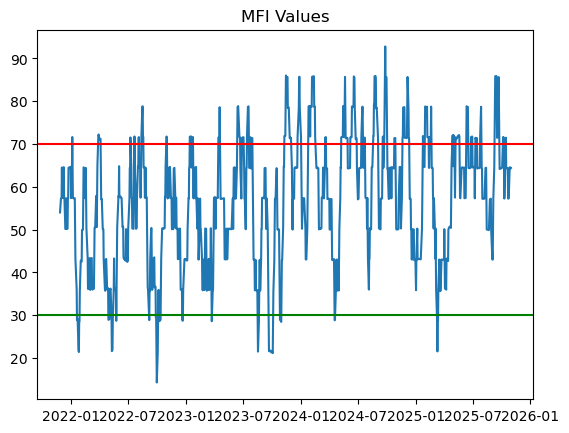

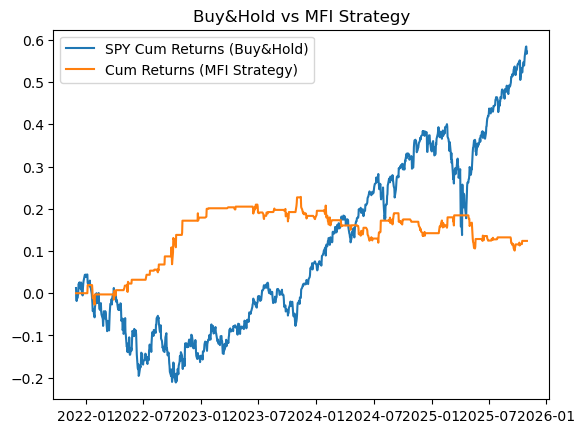

In [ ]:
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt

TICKER = "SPY"
MFI_LENGTH = 14 
OVERBROUGHT = 70
OVERSOLD = 30 
LOOKBACK = 1000

def get_data(ticker = TICKER):
    df = yf.download(ticker, start="1993-04-01")
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-LOOKBACK:,:]

def add_MFI(df, length = MFI_LENGTH):
        # Step 1: Build the MFI Index
    df["Average_Price"] = (df["High"]+df["Low"]+df["Close"])/3
    df["Money_Flow"] = df["Volume"]*df["Average_Price"]
    # 14 Period Positive & Negative Money Flow
    df["Pos_Flow"] = np.where(df["Average_Price"].diff()>0, df["Average_Price"], 0)
        # diff() == Delta == Change in Prices from One Day to the next
    df["Neg_Flow"] = np.where(df["Average_Price"].diff()<0, df["Average_Price"], 0)
    # Money Flow Ratio - Rolling Average 
    df["MFR"] = df["Pos_Flow"].rolling(window=length).sum() / df["Neg_Flow"].rolling(window=length).sum()
    df["MFI"] = (100 - 100 / (1 + df["MFR"]))

        # Step 2: Plot the MFI Index
    plt.figure()
    plt.plot(df["MFI"])
    plt.title("MFI Values")

        # Step 3: Draw Overbought & Oversold lines
    plt.axhline(OVERBROUGHT, color="red")
    # When the indicator line is above the red line --> asset overbought/overvalued     
    # Short Signal (Sell) triggered when the indicator line crosses above the red line
    plt.axhline(OVERSOLD, color="green")
    # When the indicator line is below this green line --> asset oversold/undervalued 
    # Long Signal (Buy) triggered when the indicator line crosses above the green line

    return df.dropna()

def add_strategy(df, overbrought= OVERBROUGHT, oversold=OVERSOLD):
    df["Strategy"] = np.where(df["MFI"] > overbrought, -1, 
                    np.where(df["MFI"] < oversold, 1, 0))
    df["Strategy"] = df["Strategy"].shift(1)
    
    return df 

def test_strategy(df):
        # Step 1: Test Strategy
    # Test for when we buy below OVERSOLD and sell above OVERBROUGHT
    df["asset_cum_returns"] = (1 + df["Close"].pct_change()).cumprod() - 1
    # For each day: 
        # Daily percentage return: pct_change = (price_today - price_yesterday) / price_yesterday = 0.2 ... -0.1
        # Convert Daily Returns into Growth Factors: (1 + ...) = 1.02 ... -0.99
        # Multiply all Daily Growth Factors: cumprod() = 1.02 * 0.99 = 1.0098
        # Convert Growth Factors back to Percentage : -1 = 0.0098 = +0.98%
    df["strategy_cum_returns"] = (1 + df["Close"].pct_change() * df["Strategy"]).cumprod() - 1
    # For each day:
        # *df["Strategy"]: Strategy Column contains 1s and -1s

        # Step 2: Plot Strategy
    plt.figure()
    plt.plot(df["asset_cum_returns"])
    plt.plot(df["strategy_cum_returns"])
    plt.legend([f"{TICKER} Cum Returns (Buy&Hold)", "Cum Returns (MFI Strategy)"])
    plt.title("Buy&Hold vs MFI Strategy")

    return df

def main():
    df = get_data()
    df = add_MFI(df)
    df = add_strategy(df)
    df = test_strategy(df)
    return df

main()
print(df.tail())

## For a standalone basis in teh course of the last 10000 days, you only lose your money
## There are a lot of instances, where they overcome the S&P 500, but not always
